In [21]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from helpers import preprocess, evaluate

%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# Chapter IV - Fit Machine Learning Models
Perform feature engineering on the combined training & test dataset before fitting machine learning models.

In [2]:
processed_df, features = preprocess("input/train.csv", "input/test.csv")
print("Selected features: ", features)
print(processed_df.shape)
processed_df.head()

Index(['PassengerId', 'Age', 'Room', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Survived', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Sex_female', 'Sex_male'],
      dtype='object')
Number of passengers with age data: 1046
Number of passengers with no age data: 263
Selected features:  ['Room', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Sex_female', 'Sex_male']
(1309, 29)


,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Predicted_Age,Name
0,1,22.0,49.615917,7.2500,0,3,1,0.0,0,0,...,1,0,0,1,0,0,0,1,22.0,"Braund, Mr. Owen Harris"
1,2,38.0,85.000000,71.2833,0,1,1,1.0,0,0,...,0,0,0,0,1,0,1,0,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,3,26.0,49.615917,7.9250,0,3,0,1.0,0,0,...,1,0,1,0,0,0,1,0,26.0,"Heikkinen, Miss. Laina"
3,4,35.0,123.000000,53.1000,0,1,1,1.0,0,0,...,1,0,0,0,1,0,1,0,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,5,35.0,49.615917,8.0500,0,3,0,0.0,0,0,...,1,0,0,1,0,0,0,1,35.0,"Allen, Mr. William Henry"


Split the full dataset with all selected features well prepared.

In [3]:
train_df = processed_df[processed_df.Survived.notnull()]
test_df = processed_df[processed_df['Survived'].isnull()]
print("Dimension of training data: %s" %str(train_df.shape))
print("Dimension of test data: %s" %str(test_df.shape))

Dimension of training data: (891, 29)
Dimension of test data: (418, 29)


Normalize the passengers' name by removing the quotation mark

In [4]:
test_df["cleaned_name"] = test_df["Name"].apply(lambda name: name.replace('\"', ''))
ground_truth_df = pd.read_csv("input/ground-truth.csv")
ground_truth_df["cleaned_name"] = ground_truth_df["name"].apply(lambda name: name.replace('\"', ''))
test_df = pd.merge(test_df, ground_truth_df[["cleaned_name", "age", "survived"]], how="left",
                   left_on=["cleaned_name", "Age"], right_on=["cleaned_name", "age"])
test_df = test_df.rename(columns={"survived": "Ground_Truth"})
test_df.head()

,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Predicted_Age,Name,cleaned_name,age,Ground_Truth
0,892,34.5,49.615917,7.8292,0,3,0,NaN,0,0,...,1,0,0,0,1,34.5,"Kelly, Mr. James","Kelly, Mr. James",34.5,0
1,893,47.0,49.615917,7.0000,0,3,1,NaN,0,0,...,0,1,0,1,0,47.0,"Wilkes, Mrs. James (Ellen Needs)","Wilkes, Mrs. James (Ellen Needs)",47.0,1
2,894,62.0,49.615917,9.6875,0,2,0,NaN,0,0,...,1,0,0,0,1,62.0,"Myles, Mr. Thomas Francis","Myles, Mr. Thomas Francis",62.0,0
3,895,27.0,49.615917,8.6625,0,3,0,NaN,0,0,...,1,0,0,0,1,27.0,"Wirz, Mr. Albert","Wirz, Mr. Albert",27.0,0
4,896,22.0,49.615917,12.2875,1,3,1,NaN,0,0,...,0,1,0,1,0,22.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)","Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1


Verify complete match between test data and ground truth

In [5]:
test_df[test_df["Ground_Truth"].isnull()]

,PassengerId,Age,Room,Fare,Parch,Pclass,SibSp,Survived,Deck_A,Deck_B,...,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Predicted_Age,Name,cleaned_name,age,Ground_Truth


In [6]:
valid_features = features.copy()
valid_features.append('Predicted_Age')
print(valid_features)

['Room', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Sex_female', 'Sex_male', 'Predicted_Age']


## 4.1 Logistic Regression

In [9]:
survival_logreg = LogisticRegression()
survival_logreg.fit(train_df[valid_features], train_df['Survived'])
print(survival_logreg)
evaluate(survival_logreg, test_df[valid_features], test_df['Ground_Truth'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy =  0.772727
Precision = tp / (tp + fp), Precision =  0.772727
Recall = tp / (tp + fn), Recall =  0.772727
ROC =  0.763924


## 4.2 Random Forest
Fit baseline model.

In [13]:
survival_rf = RandomForestClassifier()
survival_rf.fit(train_df[valid_features], train_df['Survived'])
print(survival_rf)
evaluate(survival_rf, test_df[valid_features], test_df['Ground_Truth'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy =  0.767943
Precision = tp / (tp + fp), Precision =  0.767943
Recall = tp / (tp + fn), Recall =  0.767943
ROC =  0.751388


In [14]:
# Examine the parameters used by our current forest
print('Parameters currently in use:\n')
pprint(survival_rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Perform grid search on model parameters

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(train_df[valid_features], train_df['Survived'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [19]:
print(rf_random.best_params_)
evaluate(rf_random.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

{'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}
Accuracy =  0.772727
Precision = tp / (tp + fp), Precision =  0.772727
Recall = tp / (tp + fn), Recall =  0.772727
ROC =  0.752751


Plot feature importance

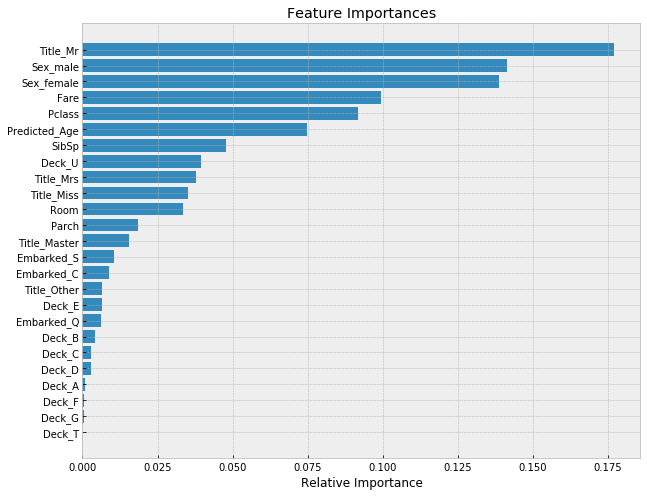

In [29]:
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(importances)

fig= plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [valid_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 4.3 Support Vector Machine

In [30]:
survival_svm = SVC(gamma='auto')
survival_svm.fit(train_df[valid_features], train_df['Survived'])
print(survival_svm)
evaluate(survival_svm, test_df[valid_features], test_df['Ground_Truth'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy =  0.686603
Precision = tp / (tp + fp), Precision =  0.686603
Recall = tp / (tp + fn), Recall =  0.686603
ROC =  0.677313


In [37]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 5, 10, 50]
    gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    svc_random = RandomizedSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    svc_random.fit(X, y)
    return svc_random

In [38]:
svc_random = svc_param_selection(train_df[valid_features], train_df['Survived'], 5)
print(svc_random.best_params_)
evaluate(svc_random.best_estimator_, test_df[valid_features], test_df['Ground_Truth'])

{'gamma': 0.01, 'C': 5}
Accuracy =  0.688995
Precision = tp / (tp + fp), Precision =  0.688995
Recall = tp / (tp + fn), Recall =  0.688995
ROC =  0.67427


## 4.4 XGBoost

# References
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
    
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://medium.com/@praveen.orvakanti/this-will-help-you-score-95-percentile-in-the-kaggle-titanic-ml-competition-aa2b3fd1b79b